# Gaussian Processes and infinite Neural Nets

Gaussian Processes (GPs) generalize Gaussian distributions to random variables that are functons. As such, they are a powerful tool for regression and Bayesian inference. In the last years they have received increased attention with the increased interest in machine learning. One thing that has always intrigued me about GPs is that there is a connection to infinite Neural Networks, which is something that I hear at a seminar once. In this article I want to give an introduction to GPs with the ultimate goal of exploring the connection between Neural Nets and GPs. For this article, I will be using my favorite language for numerical computing, Julia.

## Recap of Gaussian distributions

Before we get started, we need to introduce GPs and motivate their use. To do so, we start with a short introduction of multivariate Gaussians and conditional Gaussians as we will make heavy use of them. Readers familiar with the topic may want to skip the introduction.

### Multivariate Gaussian distributions

We introduce the multivariate Gaussian distribution, which is defined as

$$\mathcal{N}(x | \mu, \Sigma) = \frac{1}{\sqrt{ (2 \pi)^d |\Sigma|}} \exp \left\{ - \frac{1}{2} (x - \mu)^T \, \Sigma^{-1} \, (x - \mu)\right\}.$$

The parameters of the distribution are the mean $\mu \in \mathbb{R}^d$ and the covariance matrix $\Sigma \in \mathbb{R}^{d \times d}$. We can restrict our analysis to symmetric positive definite matrices $\Sigma$, as the antisymmetric part of $\Sigma$ does not contribute to the quadric form in the exponent.

Let us load some packages and then define a multivariate Gaussian in 2D. In Julia, we can make use of the `Distributions` package to do this.

In [1]:
using LinearAlgebra
using Random, Distributions
using Plots # for plotting
Random.seed!(123) # this sets the random seed to 123, so that our code becomes reproducible
theme(:vibrant) # select the color theme for aesthetic reasons

In [2]:
d = 2
μ = Random.randn(d)
X = Random.randn(d, d)
Σ = X'*X

dist = MvNormal(μ, Σ)

FullNormal(
dim: 2
μ: [1.1902678809862768, 2.04817970778924]
Σ: [1.5167137980972474 -0.7586450344468244; -0.7586450344468244 0.5991970596857172]
)


We can visualize the resulting distribution and sample from it. Sampling from the distribution is as simple as `x = rand(dist, n)`, which gives us `n` samples from `dist`. The syntax `(x,y)->Distributions.pdf(dist,[x,y])` is used to extract the PDF of the distribution in its functional form for plotting.

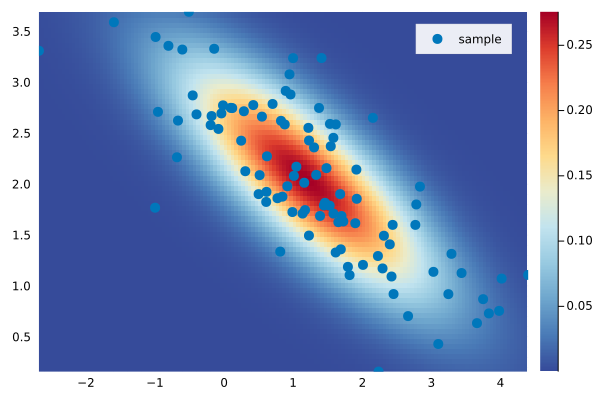

In [3]:
n = 100
x = rand(dist, n)

xmin = min(x[1,:]...)
xmax = max(x[1,:]...)
ymin = min(x[2,:]...)
ymax = max(x[2,:]...)

heatmap(xmin:0.05:xmax, ymin:0.05:ymax, (x,y)->Distributions.pdf(dist,[x,y]))
scatter!(x[1,:], x[2,:], label="sample", xlims = (xmin, xmax), ylims = (ymin, ymax))

### Conditional Gaussians

Let us discuss conditional distributions. We stick to the common practice of distinguishing between random variables denoted by capital letters and their actual realizations denoted by lowercase letters. Assume $X \sim \mathcal{N}(\mu, \Sigma)$, where we have observed the first $k$ components $x_1, x_2, \dots, x_k$ of $X$. We are interested in knowing the conditional contribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k)$ for the remaining, unobserved variables. For this purpose, let us partition the covariance matrix and the mean according to the variables:

$$
x = \begin{bmatrix}
    x_a \\
    x_b
    \end{bmatrix},
\qquad
\mu = \begin{bmatrix}
    \mu_a \\
    \mu_b
    \end{bmatrix},
\qquad
\Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
    \end{bmatrix}.
$$

Here, the subscript $a$ corresponds to the first $k$ entries, which are the observed entries, whereas $b$ corresponds to the remaining $d-k$ entries. One can show that the conditional distribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k) = p(x_b | x_a)$ is a multinomial Gaussian itself, i.e. 

$$
p(x_b | x_a) = \mathcal{N}(x_b | \mu_{b|a}, \Sigma_{b|a}),
$$

where $\mu_{b|a}, \Sigma_{b|a}$ are the parameters of the conditional distribution. By inserting the partitioned variables and re-shuffling the terms in the exponent, we find that $\mu_{b|a}$ is determined by the conditioned mean

$$
\mu_{b|a} = \mu_b + \Sigma_{ba} \Sigma_{aa}^{-1} (x_a - \mu_a)
$$

and conditioned co-variance matrix

$$
\Sigma_{b|a} = \Sigma_{bb} - \Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab}.
$$

The attentive reader may recognise this as the Schur complement, which appears when the blocked covariance matrix $\Sigma$ is factored and the degrees of freedom corresponding to $a$ are factored out.

### Marginalization of Gaussians

We have seen that the conditional distribution of a multivariate Gaussian is another multivariate Gaussian as well. Another nice property applies to marginal distributions. We recall that the marginal distribution over $x_b$ is obtained by intergrating out $x_a$. One can show that after inserting the partitioned Gaussian, one finds the satisfying result

$$
p(x_b) = \int p(x_a, x_b) \, \mathrm{d} x_a =
\int \mathcal{N}\left(x_b \bigg|
\begin{bmatrix}
    \mu_a \\
    \mu_b
\end{bmatrix},
\begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
\end{bmatrix}
\right) 

\, \mathrm{d} x_a = \mathcal{N}(x_b | \mu_b, \Sigma_{bb}).
$$


## Gaussian Processes as generalizations of multivariate Gaussians

Now that we have seen how the Gaussian distribution is generalized to $d$ dmensions, we may ask: "What if the random variable was a function?" This is where Gaussian Processes come in.

### Gaussian Processes

**Definition**: For any index set $S$, a *Gaussian Process (GP)* on $T$ is a collection of random variables $\{Y_x; \, x \in S\}$, of which any finite subset $[Y_{x_1},Y_{x_2},\dots,Y_{x_k}]^T$ is a multivariate Gaussian.

In other words, for any number $k \in \mathbb{N}$ of samples taken at indices $x = [x_1,x_2,\dots,x_k]^T$, the random variables $\{Y_{x_1},Y_{x_2},\dots,Y_{x_k}\}$ jointly follow a multivariate Gaussian. This definition seems somewhat unpractical, thankfully however, we can prescribe the Gaussian Process by specifying functions $m(x)$ and $K(x,x')$, such that

$$
Y =
[Y_{x_1},Y_{x_2},\dots,Y_{x_k}]^T
% \begin{bmatrix}
% Y_{x_1} \\
% Y_{x_2} \\
% \vdots \\
% Y_{x_k}
% \end{bmatrix}
\sim \mathcal{N}(\mu, \Sigma)
$$

with mean and covariance given by

$$
\mu_i = m(x_i), \qquad \Sigma_{ij} = K(x_i, x_j).
$$

Informally, we can think of infinite dimensiona vectors being functions. For functions $f$ sampled from the GP, we simply write

$$
f(x) \sim GP(m(x), K(x,x')).
$$

We can think of this as the infinite variant of the marginalization property, as any finite subset of points will be described by the corresponding "marginalized" mean $m(x)$ and covariance matrix $K(x,x')$.

### Radial basis kernel

Let us explore some GPs. As we have pointed out, it suffices to specify a positive semi-definite kernel function and a mean. A popular kernel is the radial-basis function (RBF) kernel

$$
K(x,x') = \exp \left\{ - \frac{1}{2\sigma^2} ||x - x'||^2\right\},
$$

where $\sigma$ is some parameter controlling the width of the kernel. Due to Julia's functional nature, defining the RBF kernel is straight-forward.

In [4]:
K(xa, xb; σ=1.0) = exp.(- [norm(a).^2 for a in (xa .- xb)] ./ (2.0 * σ^2)) # RBF kernel for matrix valued-inputs

K (generic function with 1 method)

We visualize the kernel function.

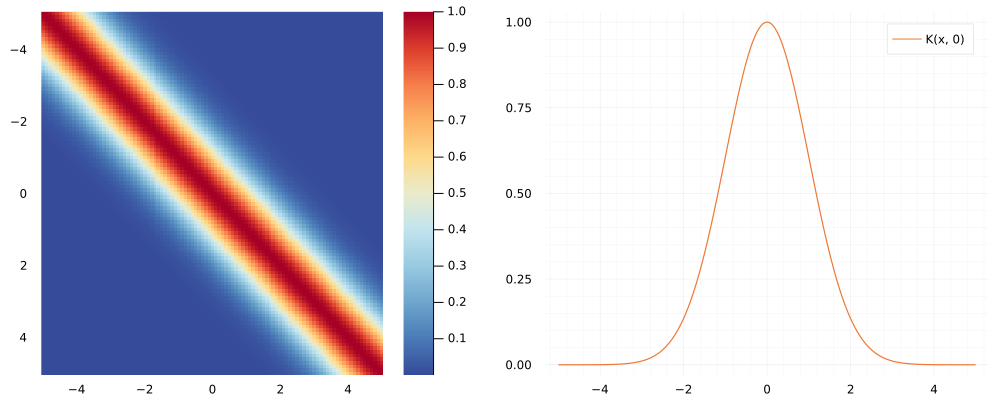

In [5]:
function visualize_kernel(kernel)
  plot1 = heatmap(-5:0.1:5, -5:0.1:5, kernel, yflip = true)

  xa = collect(-5:0.05:5)
  xb = zero(xa)
  plot2 = plot(xa, kernel(xa, xb), label="K(x, 0)")

  plot(plot1, plot2, layout = @layout([a{1.0h} b]), size=(1000,400))
end

visualize_kernel(K)

The figure on the right illustrates the kernel function $K(x, 0)$ at a fixed location $x'=0$. By varying $x'$, we slide the kernel across the domain of $x$. This implies that the covariance $K(x, x')$ for any two points $x, x'$ will fall off exponentially with the distance squared.

Let us plot some realizations of the corresponding GP. Observing realizations is as easy as picking $n$ points on the real axis $[x_1, x_2, \dots, x_n]^T$ and observing $f(x_i)$ at these points. To simplify this, we set $m(x) = 0$. By the definition of GPs, we have that $[f(x_1), f(x_2), \dots, f(x_n)]^T \sim \mathcal{N}(0, \Sigma)$. In other words, we need to sample $n$ observations from the multivariate Gaussian $\mathcal{N}(0, \Sigma)$, where the covariance matrix $\Sigma$ is defined by $\Sigma_{ij} = K(x_i, x_j)$. The following code samples $10$ realizations from the Gaussian process defined by $m(x) = 0$ and the radial-basis kernel $K$.

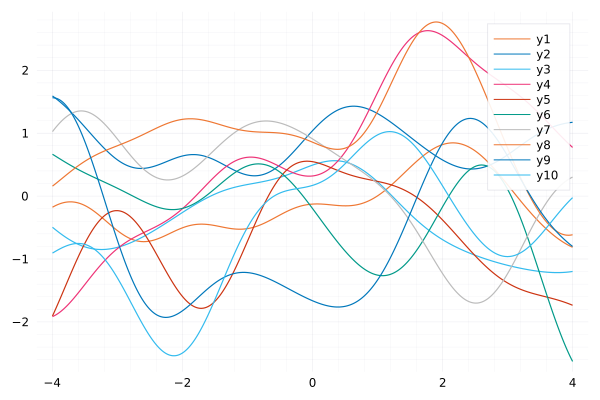

In [6]:
function visualize_gp_samples(mean, kernel, nsamples; bounds=(0,1))
  mesh = LinRange(bounds[1], bounds[2], 500)

  S = [kernel(xa,xb) for xa in mesh, xb in mesh]
  # The following line is a fix to make sure that S is positive definite.
  # To do so, we define a threshhold tol and add the identity matrix to make this the new minimum eigenvalue.
  if !isposdef(S)
    S = S + (1e-12 -  min(eigvals(S)...)) * I
  end
  GP = MvNormal(mean(mesh), S) # this is the workaround

  # sampling the distribution gives us divverent instance of the random variable f
  samples = rand(GP,nsamples)
  plot(mesh,samples)
end

visualize_gp_samples(zero, K, 10, bounds=(-4,4))


We observe that the ten samples are smoothly varying around the mean $0$. We have effectively created a distribution over some function space. For now, we are nto concerned with the precise properties of this function space. Rather, let us explore some other kernel functions.

### Ornstein-Uhlenbeck process

Let us use Lagrange function, which resembles the functional form of the PDF that produces white noise. It is defined as

$$
K(x,x') = \exp \left\{ - \frac{||x - x'||}{l}\right\},
$$

In [7]:
L(xa, xb; l=1.) = exp.(- [norm(a) for a in (xa .- xb)] ./ l) 

L (generic function with 1 method)

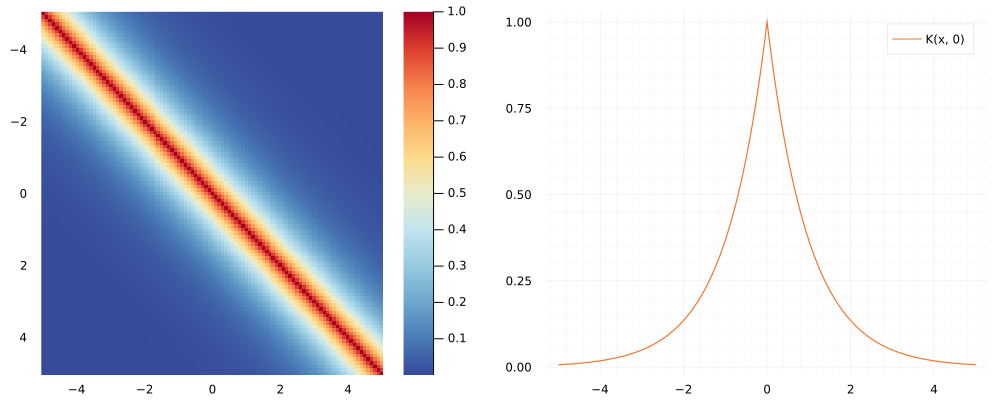

In [8]:
visualize_kernel(L)

We observe that the kernel function is sharply peaked around $x'=0$. We use the same code as before to sample the Gaussian Process:

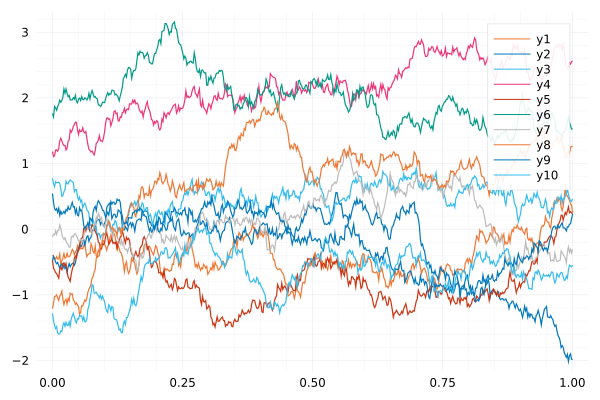

In [9]:
visualize_gp_samples(zero, L, 10)

We observe that the resulting function are not smooth everywhere and resemble realizations from a stochastic process. In fact, one can indeed show that the realizations that we observe are equivalent to the random walk of a Brownian particle subject to friction. This is also known as the *Ornstein-Uhlenbeck process*. It is evident that the smoothness properties of the resulting functions are related to the regularity (or lack thereof) of the kernel function.

## Gaussian Process regression (Kriging)

We have seen some examples of GPs and are interested in what we can do with them. A powerful application for GPs is regression, which is also known as Kriging in this context. Let us assume that we have some measurements of a function $t(x)$ at points $x_i$ and that we would like to predict $t(x)$ everywhere else. Instead of measuring $t(x)$ directly however, we observe $Y = t(x) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is a noise variable that adds uncertainty to the measurement. We could model this by prescribing the conditional distribution $p(y|x) = \mathcal{N}(y | t(x), \sigma^2)$. Alternatively, we can also interpret this as a Gaussian process $GP(t(x), \sigma^2 \delta(x-x'))$. $\delta(x-x')$ denotes the Dirac delta, which adds uncorrelated noise for $x \neq x'$.

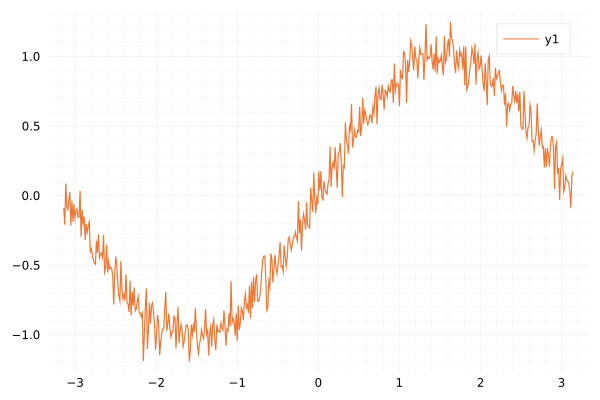

In [10]:
σ=0.1
D(xa, xb; σ=1.0) = σ^2 .* [Float64(norm(a) == 0.) for a in (xa .- xb)]
# visualize_kernel(D)
f(x) = sin.(x)
visualize_gp_samples(f, (xa,xb)->D(xa,xb,σ=σ), 1, bounds=(-π,π))

Let us make this more concrete. We choose $f(x) = \sin (x)$ and $\sigma = 0$. This gives us a deterministic outcome, as there will be no noise on the prior. We sample eight points at random from the interval $[- \pi, \pi]$, which will serve as our training points.

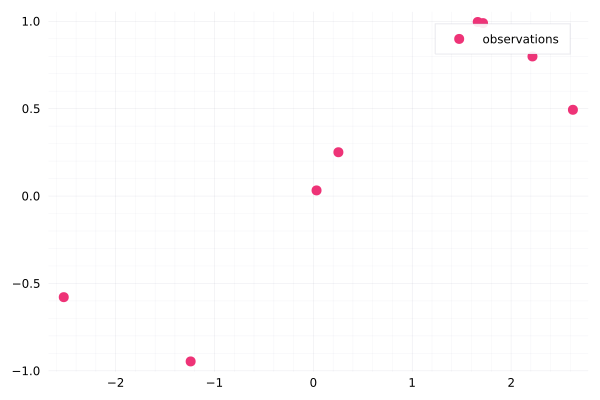

In [11]:
# sample observed points from the GP
σ = 0.0
n_obs = 8
x_obs = rand(Uniform(-π,π), n_obs)
S_obs = [D(xa, xb, σ=σ) for xa in x_obs, xb in x_obs]
if !isposdef(S_obs)
  S_obs = S_obs + (1e-12 -  min(eigvals(S_obs)...)) * I
end
GP = MvNormal(f(x_obs), S_obs)
f_obs = rand(GP, 1)

# plot the observations
scatter(x_obs, f_obs, label="observations", color=4)

After observing $k$ points from this Gaussian Process, we are interested in constructing a posterior distribution

$$
Y \sim GP(m(x), K(x,x'))
$$

Luckily, we can use conditional Gaussians to make a prediction on the query points. We assume that $x_1, x_2, \dots, x_k$ are the reference points, at which we have observed $y_1, y_2, \dots, y_k$, and $x_{k+1}, x_{k+2}, \dots, x_d$ the query points at which we would like to make a prediction $y_{k+1}, y_{k+2}, \dots, y_d$ using the GP posterior. As before, we will use the subscript $a$ to denote the first $k$ reference points and $b$ the remaining query points. By the definition of GPs, the vector $x$ follows

$$
Y = 
\begin{bmatrix}
    Y_a \\
    Y_b
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
    \mu_a \\
    \mu_b
\end{bmatrix},
\begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
\end{bmatrix}
\right).
$$

To make a prediction on the query points, all we need to do is compute the conditional Gaussian distribution and compute the required terms in $\Sigma$ and $\mu$. We make the simple choice of assuming a zero prior, such that $\mu_a = 0$. The terms in $\Sigma_{aa}$, $\Sigma_{ba}$ and $\Sigma_{bb}$ are computed by plugging the points $x_i$ into the Kernel. We rcall that the conditional Gaussian distribution is defined by

$$
\mu_{b|a} = \Sigma_{ba} \Sigma_{aa}^{-1} y_a
$$

and

$$
\Sigma_{b|a} = \Sigma_{bb} - \Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab}.
$$

The maximum likelihood prediction in this case is given by the mean $\mu_{b|a}$ and the variance can be estimated by taking the diagonal entries of $\Sigma_{b|a}$. Let us visualize this with some code.


In [12]:
# compute the function of the posterior
function compute_gp_posterior(x_obs, f_obs, x_mesh, Kpost, Kprior)

  Σaa = Kpost(x_obs*ones(length(x_obs))', ones(length(x_obs))*x_obs') + Kprior(x_obs*ones(length(x_obs))', ones(length(x_obs))*x_obs')
  Σba = Kpost(x_mesh*ones(length(x_obs))', ones(length(x_mesh))*x_obs')
  Σbb = Kpost(x_mesh*ones(length(x_mesh))', ones(length(x_mesh))*x_mesh')

  # the regression part
  m = Σba * (Σaa \ f_obs) # we assume μ=0 for the prior
  S = Σbb - Σba * (Σaa \ Σba')
  return m, S
end

x_mesh = LinRange(-2*π,2*π,100)
Kprior = (xa, xb) -> D(xa, xb, σ=σ)
Kpost = (xa, xb) -> K(xa, xb, σ=1.0)

m, S = compute_gp_posterior(x_obs, f_obs, x_mesh, Kpost, Kprior)

([-9.369695918338859e-5; -0.00015075979983293126; … ; -0.005352845937511571; -0.003520077442188424], [0.9999989337571946 0.9919746613050364 … 1.169090721559824e-6 7.794250769238117e-7; 0.9919746613050364 0.9999972786788515 … 1.8644416057254722e-6 1.243011747806888e-6; … ; 1.1690907215600333e-6 1.864441605725805e-6 … 0.9998702236000084 0.9918910258492498; 7.794250769239503e-7 1.2430117478071082e-6 … 0.9918910258492498 0.9999438745325055])

The resulting mean and covariance matrix determine the distribution on all points of the domain. To visualize the posterior GP, we plot the mean and a confidence interval of $\pm 2 \sigma$. The latter can be extracted by taking the diagonal entries of the posterior covariance matrix.

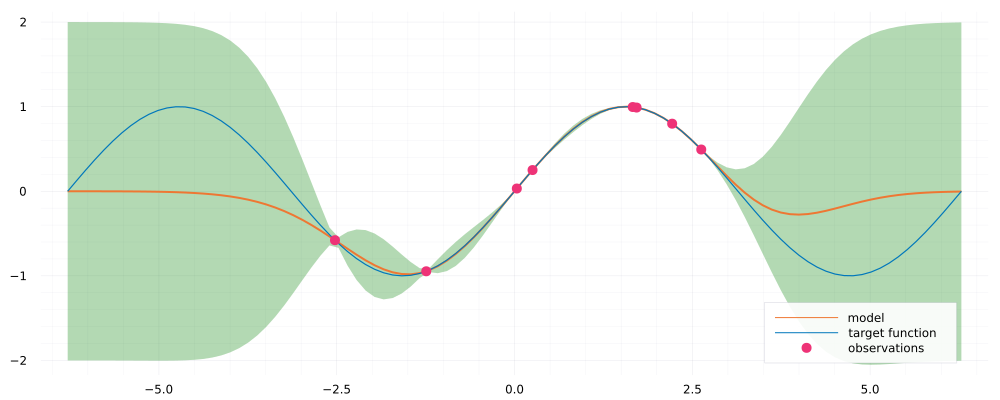

In [13]:
# plot the posterior mean, as well as its 2σ confidence interval
var = sqrt.(diag(S))
plot(x_mesh, m, ribbon=(2*var, 2*var), fc=:green, fa=0.3, label="model", linewidth=2, legend=:bottomright, size=(1000,400))
plot!(x_mesh, f(x_mesh), label="target function")
scatter!(x_obs, f_obs, label="observations", color=4)

This is very nice. Not only where we able to fit the data points, but we also got a posterior distribution, that gives us a confidence interval. Because the prior distribution was deterministic, there is no uncertainty around the observed points. However, in between these points we observe that the covariance increases. Moreover, the kernel that we chose encodes some regularity, which results in smooth realizations, if we were to sample this GP.

Let us now re-introduce noise into our prior. To this end, we set $\sigma = 0.1$, and adapt the GP prior accordingly. The modified GP is determined by

$$
Y = 
\begin{bmatrix}
    Y_a \\
    Y_b
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
    \mu_a \\
    \mu_b
\end{bmatrix},
\begin{bmatrix}
    \Sigma_{aa} + \sigma^2 I & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
\end{bmatrix}
\right),
$$

which means that the prediction is given by

$$
\mu_{b|a} = \Sigma_{ba} (\Sigma_{aa} + \sigma^2 I)^{-1} y_a.
$$

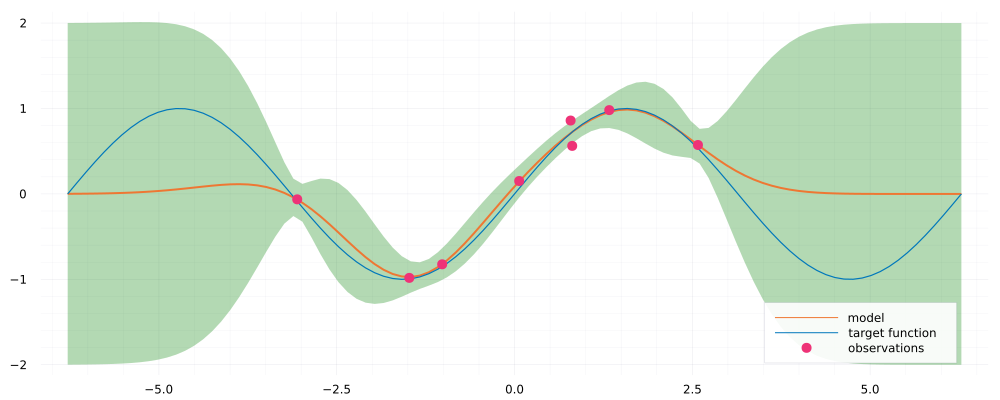

In [14]:
# sample observed points from the GP
σ = 0.1
n_obs = 8
x_obs = rand(Uniform(-π,π), n_obs)
S_obs = [D(xa, xb, σ=σ) for xa in x_obs, xb in x_obs]
if !isposdef(S_obs)
  S_obs = S_obs + (1e-12 -  min(eigvals(S_obs)...)) * I
end
GP = MvNormal(f(x_obs), S_obs)
f_obs = rand(GP, 1)

# take the same mesh, but adapt the prior to the new variance
x_mesh = LinRange(-2*π,2*π,100)
Kprior = (xa, xb) -> D(xa, xb, σ=σ)
Kpost = (xa, xb) -> K(xa, xb, σ=1.0)

m, S = compute_gp_posterior(x_obs, f_obs, x_mesh, Kpost, Kprior)

# plot the posterior mean, as well as its 2σ confidence interval
var = sqrt.(diag(S))
plot(x_mesh, m, ribbon=(2*var, 2*var), fc=:green, fa=0.3, label="model", linewidth=2, legend=:bottomright, size=(1000,400))
plot!(x_mesh, f(x_mesh), label="target function")
scatter!(x_obs, f_obs, label="observations", color=4)

We observe very similar results, with the difference of there being some uncertainty around the observed points. This is nice, as we can clearly see that this method is robust with respect to the noise in the observed data. Unfortunately, this plot also shows one of the main limitations of this approach. We notice that at the boundaries of the domain there is no way to predict the true GP. As such, it converges to the prior, which has zero mean.

### Comparison to Bayesian linear regression

In the setting of Bayesian linear regression, we fit the function with

$$
f(x) = wx + b,
$$

where the parameters $w, b \in \mathbb{R}$ follow the prior distributions $w \sim \mathcal{N}(0, \sigma^2_w)$ and $b \sim \mathcal{N}(0, \sigma^2_b)$, with corresponding hyperparameters $\sigma^2_w$ and $\sigma^2_b$. This also forms a Gaussian Process, which we can see by forming the covariance of $f$ evaluated on two points $x$ and $x'$, given by

$$
\begin{align*}
\mathop{cov}[f(x), f(x')] &= \mathbb{E}[f(x)f(x')] - \mathbb{E}[f(x)]\mathbb{E}[f(x')]\\
&= \mathbb{E}[(wx + b)(wx' + b)]\\
&= \sigma^2_w x x' + \sigma^2_b = K(x,x').
\end{align*}
$$

This can also be interpreted as a kernel. We fit our sinusoidal observations with this polynomial kernel GP.

In [15]:
P(xa, xb; σw=1.0, σb=1.0) = σw^2*(xa.*xb) .+ σb^2

P (generic function with 1 method)

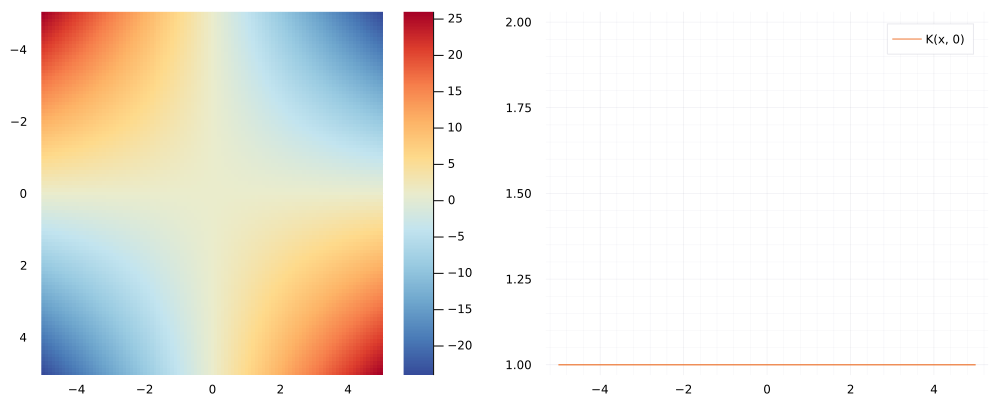

In [16]:
visualize_kernel(P)

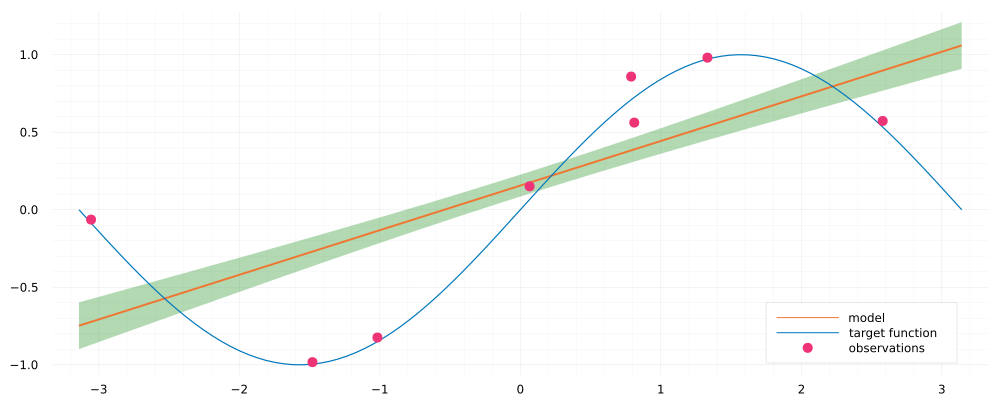

In [17]:
# take the same mesh, but adapt the prior to the new variance
x_mesh = LinRange(-π,π,100)
Kprior = (xa, xb) -> D(xa, xb, σ=σ)
Kpost = (xa, xb) -> P(xa, xb)

m, S = compute_gp_posterior(x_obs, f_obs, x_mesh, Kpost, Kprior)

# plot the posterior mean, as well as its 2σ confidence interval
var = sqrt.(diag(S))
plot(x_mesh, m, ribbon=(2*var, 2*var), fc=:green, fa=0.3, label="model", linewidth=2, legend=:bottomright, size=(1000,400))
plot!(x_mesh, f(x_mesh), label="target function")
scatter!(x_obs, f_obs, label="observations", color=4)

Unsurprisingly, this is not a particularly good fit, as we are fitting the data with a linear function. Moreover the result looks very similar to what we could expect when we perform Bayesian regression. To see how both methods compare, let us take a few steps back and recall how we compute the estimator in a Bayesian regression setting. As we did previously, we assume  $w \sim \mathcal{N}(0, \sigma^2_w)$ and $b \sim \mathcal{N}(0, \sigma^2_b)$. After observing the data $x_a, y_a$, the Maximum-Likelihood estimate (MLE) is given by

$$
y_b = \Phi_b (\Phi_a^T \Phi_a)^{-1} \Phi_a^T y_a,
$$

where $\Phi_a = \Phi(x_a)$ and $\Phi_b = \Phi(x_b)$ are defined by

$$
\Phi(x) = 
\begin{bmatrix}
\varphi_1(x_1) & \varphi_2(x_1) & \dots & \varphi_p(x_1) \\
\varphi_1(x_2) & \varphi_2(x_2) & & \vdots \\
\vdots & & \ddots & \\
\varphi_1(x_d) & \dots & & \varphi_p(x_d)\\
\end{bmatrix}.
$$

We have used $\varphi_i$ to denote the $p$ basis functions for some $p \in \mathbb{N}_0$. In the setting of polynomial regression, these could be the monomial basis functions $\varphi_i: x \rightarrow x^i$. The matrix $\Phi(x)$ is also called the design matrix or, in the case of polynomial basis functions, Vandermonde matrix. In our particular (linear) case, this matrix is

$$
\Phi(x) = 
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_d\\
\end{bmatrix}.
$$

If we instead take the Maximum-a-Posteriori (MAP) estimator, we get

$$
y_b = \Phi_b (\Phi_a^T \Phi_a + \Lambda)^{-1} \Phi_a^T y_a = \Phi_b (\Phi_a^T \Phi_a + \lambda I)^{-1} \Phi_a^T y_a.
$$

$\Lambda$ is defined as

$$
\Lambda =
\begin{bmatrix}
\sigma^2/\sigma_b^2 & 0 \\
0 & \sigma^2/\sigma_w^2\\
\end{bmatrix},
$$

and acts as a regularization term, putting the noise variance $\sigma^2$ in relation to the hyperparameters $\sigma_b^2$, $\sigma_w^2$. To simplify matters, we set $\sigma_b^2 = \sigma_w^2 = \sigma_0^2$ and $\lambda = \sigma^2 / \sigma_0^2$. 

We compare the MAP estimator to the GP prediction

$$
\mu_{b|a} = \Sigma_{ba} (\Sigma_{aa} + \sigma^2 I )^{-1} y_a,
$$

which looks similiar but is not quite the same. We recall that $\Sigma_{aa} = \Phi_a \Phi_a^T$, which for the GP is a $k \times k$ matrix, as opposed to the $p \times p$ matrix $\Phi_a^T \Phi_a$ which appears in the regression scenario. Using $\Sigma_{ba} = \Phi_b \Phi_a^T$ and the [Sherman-Morrison-Woodbury formula](https://en.wikipedia.org/wiki/Woodbury_matrix_identity), we can rewrite it as

$$
\begin{align*}
\mu_{b|a}
&= \Phi_b \Phi_a^T (\Phi_a \Phi_a^T + \sigma^2 I )^{-1} y_a \\
&= \frac{1}{\sigma^2} \Phi_b \Phi_a^T [I - \Phi_a (\sigma^2 I + \Phi_a^T \Phi_a )^{-1}\Phi_a^T]y_a \\
&= \frac{1}{\sigma^2} \Phi_b [I - \Phi_a^T \Phi_a (\sigma^2 I + \Phi_a^T \Phi_a )^{-1}] \Phi_a^T y_a \\
&= \frac{1}{\sigma^2} \Phi_b [(\sigma^2 I + \Phi_a^T \Phi_a )(\sigma^2 I + \Phi_a^T \Phi_a )^{-1} - \Phi_a^T \Phi_a (\sigma^2 I + \Phi_a^T \Phi_a )^{-1}] \Phi_a^T y_a \\
&= \Phi_b (\Phi_a^T \Phi_a + \sigma^2 I)^{-1} \Phi_a^T y_a.
\end{align*}
$$

This pleasing result is also called the push-through property. More importantly, it shows that the GP regression with a polynomial kernel is equivalent to Bayesian regression using a prior distribution on the parameters. In fact, this property is already hinted at, when we realized that the process by which we generate the data could be interpreted as a GP. As such, we have demonstrated that GPs offer a high amount of flexibility and can model a vide variety of problems. Moreover, the choice of kernel was the crucial step, which allowed us to model Bayesian regression using GPs. As such it is essential to construct kernels based on the properties we expect our functions to have.


Finally, there is an important practical difference to Bayesian regression. GPs are non-parametric, as there are no learned parameters. We have essentially skipped the step of remembering the parameters, and instead compute a prediction directly. Additionally, this comes at the cost of having to factorize a larger, $k \times k$ matrix.

### Constructing Kernels from scratch

The polynomial kernel hinted at how a kernel function can be constructed to implicitly perform regression in some basis. According to [Mercer's theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem), we can represent positive definite covariance functions $K(x,x')$ as an infinite expansion

$$
K(x,x') = \sum_{i=1}^\infty \lambda_i \varphi_i(x) \varphi_i(x'),
$$

where the basis functions $\varphi_i$ and the constants $\lambda_i$ are determined by the eigenvalue problem

$$
\int K(x,x') \varphi_i(x) \, \mathrm{d}x = \lambda_i \varphi_i(x).
$$

It is evident that this representation of $K$ essentially corresponds to the eigendecomposition of a matrix. We can use this to derive a kernel for periodic basis functions, by inserting the Fourier expansion, which yields

$$
K(x,x') = \exp \left\{- \frac{2 \sin^2(d/2)}{l^2} \right\}
$$



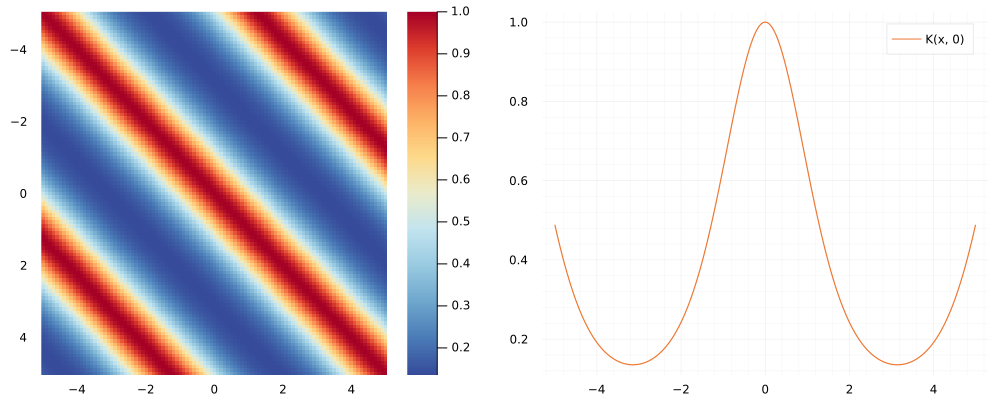

In [18]:
K(xa, xb; l=1.0) = exp.(- [2.0*sin(0.5*norm(a))^2 for a in (xa .- xb)] ./ (l^2)) # RBF kernel for matrix valued-inputs
visualize_kernel(K)

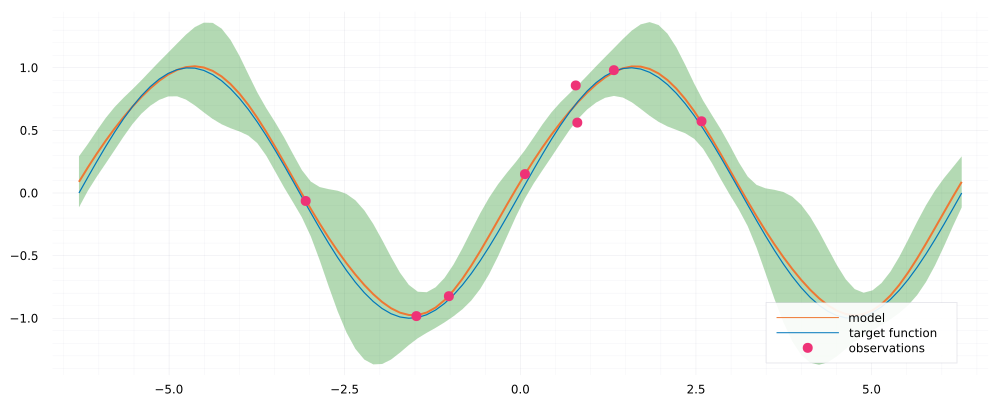

In [19]:
# take the same mesh, but adapt the prior to the new variance
x_mesh = LinRange(-2*π,2*π,100)
Kprior = (xa, xb) -> D(xa, xb, σ=σ)
Kpost = (xa, xb) -> K(xa, xb, l=1.0)

m, S = compute_gp_posterior(x_obs, f_obs, x_mesh, Kpost, Kprior)

# plot the posterior mean, as well as its 2σ confidence interval
var = sqrt.(diag(S))
plot(x_mesh, m, ribbon=(2*var, 2*var), fc=:green, fa=0.3, label="model", linewidth=2, legend=:bottomright, size=(1000,400))
plot!(x_mesh, f(x_mesh), label="target function")
scatter!(x_obs, f_obs, label="observations", color=4)

The additional information regarding the periodicity clearly healps the GP to generalize (extrapolate) better. We see that the uncertainty in the prediction has an interesting structure which follows the same periodicity as the kernel. As we have prescribed the periodicity, the uncertainty lies in the phase and amplitude of the solution.

## Connection to Neural Networks

At the beginning of this article I promised to sketch the connection to neural networks. The analysis here follows [this](https://openreview.net/pdf?id=B1EA-M-0Z) and [this article](https://www.cs.toronto.edu/~radford/ftp/pin.pdf) and we will largely stick to the notation of the former. The overarching goal of this section is to better understand the parallels between infinite Neural Nets and the GPs that they are equivalent to, such that they may be better analyzed and understood.

We consider a deep, feed-forward neural network with $L$ hidden layers. Let us denote with $x \in \mathbb{R}^{d_\text{in}}$ the input vector to the network. The $i$-th component of the input to layer $l$ is denoted similarly as $x^{l}_i$. This input is computed by applying the non-linear activation $\phi$ to the $i$-th output of the previous layer, $z_i^{l-1}$. In other words, $z_i^l$ denotes the ouput of the $i$-th neuron, after applying the affine transformation and before applying the nonlinearity. This is summarizd as

$$
\begin{align*}
z_i^l(x) &= b_i^l + \sum_{j=1}^{N_l} W^l_{ij} x_j^l(x), \\
x_i^l(x) &= \phi(z_i^{l-1}(x))
\end{align*}
$$

where $W^l_{ij}, b_i^l$ are the parameters of layer $l$ and $x_j^{l-1}(x)$ is the output of the previous layer, with $x_j^{0}(x) = x_j$. We have explicitly expressed the dependence of the output in each layer on the input vector $x$. The output of the neural network is the vector $z^L(x)$, which is the output of the last affine transformation.

### Shallow Networks and Gaussian Processes

In his seminal work 
Let us consider the simplified case of a "shallow" network with a single hidden layer, comprising $N^1$ neurons. In this case, we can express  the neural network as

$$
\begin{align*}
z_i^1(x) &= b_i^1 + \sum_{j=1}^{N_1} W^1_{ij} x^1_j(x), \\
x_j^1(x) &= \phi\left(b_j^0 + \sum_{k=1}^{d_\text{in}} W^0_{jk} x_k\right).
\end{align*}
$$

So far, we have not assumed any priors for the weight and bias parameters. In the following, we assume that in each layer $l$, bias parameters $b_i^l$ are drawn i.i.d. from a Gaussian distribution with zero mean and $\sigma_{b,l}^2$ variance. We assume the same for the weight parameters $W_{ij}^l$, which are drawn i.i.d. from a Gaussian distribution with zero mean and $\sigma_{W,l}^2$ variance.

We are interested in computing the expected outcome of $\mathbb{E}[z_i^1(x)]$ for a fixed input $x$. We observe that the output is the weighted sum of the $N_1$ activations and the bias parameter. Due to the weight and bias parameters $b_i^0$, $W^0_{ij}$ being i.i.d., we observe that $x_j^1$ and $x_{j'}^1$ will be independent for $j \neq j'$. Due to the linearity of the expected value and the independence of $x_j^1$ and $x_{j'}^1$, we can write

$$
\mathbb{E}[z_i^1(x)] = \mathbb{E}[b_i^1] + \sum_{j=1}^{N_1} \mathbb{E}[W^1_{ij} x^1_j(x)] = \sum_{j=1}^{N_1} \mathbb{E}[W^1_{ij}]\mathbb{E}[x^1_j(x)] = 0.
$$

The last step is a consequence of $\mathbb{E}[W^1_{ij}] = 0$ and the independence between $x^1_j(x)$ and the parameters $W^1_{ij}$. A similar arguments holds for $\mathbb{E}[(W^1_{ij} x^1_j(x))^2]$, which can be rewritten as

$$
\mathbb{E}[(W^1_{ij} x^1_j(x))^2] = \mathbb{E}[(W^1_{ij})^2] \mathbb{E}[(x^1_j(x))^2] = \sigma_{W,1}^2 \mathbb{E}[(x^1_j(x))^2].
$$

This term is bounded, if $x^1_j(x)$ is bounded as well. This is the case if for instance, we set the activation function to $\phi = \tanh$. Consequently, the variance of $z_i^1(x)$ is given by

$$
\operatorname{var}[z_i^1(x)] = \sigma_{b,1}^2 + N_1\sigma_{W,1}^2 \mathbb{E}[(x^1_j(x))^2].
$$

By the [multivariate CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Multidimensional_CLT), this implies that in the limit of infinite network width $N_1 \rightarrow \infty$, the prior of $z_i^1(x)$ will converge to a Gausian distribution with mean zero and variance $\sigma_{b,1}^2 + N_1\sigma_{W,1}^2 V^1(x)$. Thus, by adopting $\sigma_{W,1} = \omega_{W,1} N_1^{-1/2}$, obtain a prior with constant variance as the number of hidden units increases. More importantly, for any finite collection of inputs $x^{\alpha=1}, x^{\alpha=2}, \dots, x^{\alpha=k}$, the set $\{z_i^1(x^{\alpha=1}), z_i^1(x^{\alpha=2}), \dots, z_i^1(x^{\alpha=k})\}$ will be a multivariate Gaussian, which is precisely the definition of a GP.

Let us explore some shallow networks to get a feeling for the matter. We use the populer Julia library `Flux` to handle neural networks for us. To simplify manners, we set $\omega_{W,1}  = \sigma_{W,0} = \sigma_{b,0} = 1$ and $\sigma_{b,1} = 0$. The following code generates a neural network, which is parametrized by weights and bias parameters drawn from the specified Gaussian priors.

In [28]:
using Flux

function shallow_network(; width=100, activation=tanh)
  # initialize the weights according to our prior Distributions
  W0 = reshape(rand(Normal(0, 1), width*1), (width, 1))
  b0 = reshape(rand(Normal(0, 1), width*1), (width))
  W1 = reshape(rand(Normal(0, 1.0/width), 1*width), (1, width)) # this is the layer in which we need to rescale the variance to ensure finite variance of the joint Gaussian
  b1 = reshape(rand(Normal(0, 0), 1*1), (1)) # this one is turned off
  return Chain(Dense(W0, b0, activation), Dense(W1, b1, identity))
end

shallow_network (generic function with 1 method)

This simple function will generate shallow networks, with the specified width. We can generate functions and access their parameters in the following manner:

In [29]:
nn = shallow_network(width=100)

size(nn[2].W)

(1, 100)

Let us write a function to visualize some samples from this prior, much in the same way as we have visualized samples from GPs.

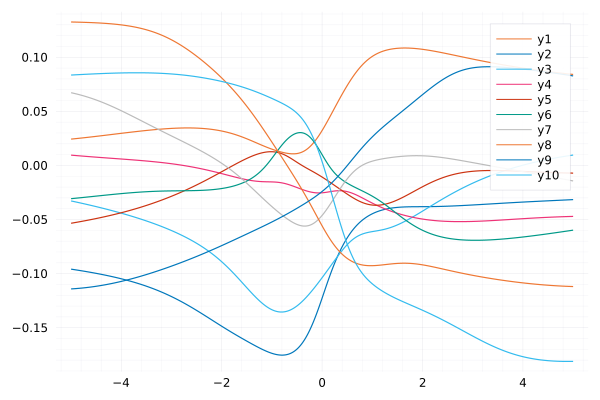

In [35]:
function visualize_nn_samples(generator, nsamples; bounds=(-5,5))
  mesh = LinRange(bounds[1], bounds[2], 500)

  nns = [generator() for i in 1:nsamples]
  graphs = [nns[i](collect(mesh'))' for i in 1:nsamples]
  plot(mesh, graphs)
end

visualize_nn_samples(()->shallow_network(width=100), 10)

We observe that this results in smooth functions with a variation that is almost always concentrated in a region around $x=0$ with a width of roughly $\sigma_{b,0}/\sigma_{W,0}$. Outside of this regions, the functions are almost always constant. Moreover, by varying the amount of hidden units, we observe that the functions become increasingly complex.


We can generate all kinds of GPs depending on the activation function that we choose. Here is another example using step functions as activation. We observe that the resulting functions resemble stochastic processes.

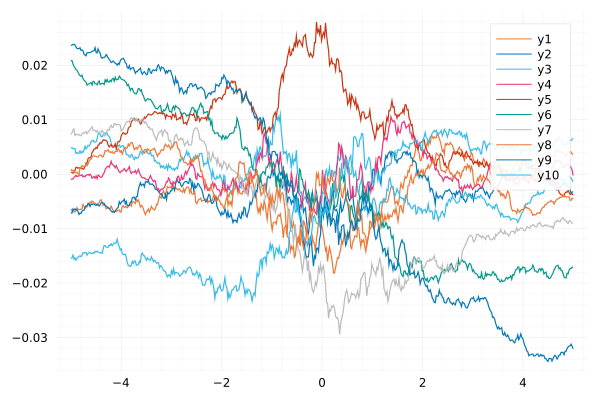

In [50]:
visualize_nn_samples(()->shallow_network(width=10000, activation=sign), 10)

To analyze neural networks with the tool of Gaussian processes, we need to determine their kernel function. More specifically, we are interested in finding the covariance for two inputs $x$ and $x'$. We have

$$
\begin{align*}
K^1(x,x') = \operatorname{cov}[z_i^1(x), z_i^1(x')] = \mathbb{E}[z_i^1(x) z_i^1(x')]
&= \sigma_{b,1}^2 + \sum_{j=1}^{N_1} \sigma_{W,1}^2 \mathbb{E}[x^1_j(x)) x^1_j(x'))] \\
&= \sigma_{b,1}^2 + \omega_{W,1}^2 C(x, x'),
\end{align*}
$$

where we have introduced $C(x, x') = \mathbb{E}[x^1_j(x)) x^1_j(x'))]$.

A shallow neural network with one hidden layer maps the input vector $x \in \mathbb{R}^d$ to

$$
y = \sum^N_{i=1} c_i \sigma(w_i^T x + b_i),
$$

where $N$ is the number of neurons in the hidden layer and $w_i, b_i \in \mathbb{R}^d$ are parameter vectors for each neuron. $\sigma$ is called an activation function and introduces a non-linearity into the model. Finally, a linear combination of all activation is taken with the linear weights $c_i \in \mathbb{R}$. If we choose $\sigma$ to be the logistic function, we can think of shallow networks to be some form of weighted majority vote over a number of logistic regressors. In typical neural networks, deep networks are utilized, where instead of taking a linear combination of the outputs of the neurons, the entire output vector is passed onto the next layer as illustraded in the figure below.

[![Illustration of single layer articial neural network](./images/single_layer_ann.svg)](https://en.wikipedia.org/wiki/Artificial_neural_network)

Illustration of a feed-forward neural network (source: https://en.wikipedia.org/wiki/Artificial_neural_network).

In [37]:
K(xa, xb; σ=1.0) = exp.(- [norm(a).^2 for a in (xa .- xb)] ./ (2.0 * σ^2)) # Arccos kernel can be derived for ReLU networks

K (generic function with 1 method)

## Conclusion

I hope I could give you an intuitive introduction to Gaussian Processes, together with some interesting properties related to Bayesian Regression and infinite Neural Nets. I find it quite fascinating how seemingly different ML approaches are connected in such unexpected ways.

While doing my research for this article, I stumbled across many interesting articles on the topic. You can find them listed below.

## References

- Lee J., Bahri Y., Novak R., Schoenholz S.S., Pennington J. and Sohl-Dickstein J. (2018). *Deep Neural Networks as Gaussian Processes.*, ICLR 2018. [openreview.net/pdf?=id=B1EA-M-0Z](https://openreview.net/pdf?id=B1EA-M-0Z)
- Nearl R.M. (1994). *Priors for Inifinite Networks.*, Technical Report, University of Toronto. [https://www.cs.toronto.edu/~radford/ftp/pin.pdf](https://www.cs.toronto.edu/~radford/ftp/pin.pdf).
- Rasmussen C.E. (2006). *Gaussian Processes for Machine Learning.* [http://www.tsc.uc3m.es/~fernando/l1.pdf](http://www.tsc.uc3m.es/~fernando/l1.pdf).
- [en.wikipedia.org/wiki/Gaussian_process](https://en.wikipedia.org/wiki/Gaussian_process) (as opened 22.12.2021).
- [en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process) (as opened 22.12.2021).
- [en.wikipedia.org/wiki/Central_limit_theorem#Multidimensional_CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Multidimensional_CLT) (as opened 22.12.2021).
- Andersen M.S. and Chen T. (2020). *Smoothing Splines and Rank Structured Matrices: Revisiting the Spline Kernel.* SIAM Journal on Matrix Analysis and Applications. [doi.org/10.1137/19M1267349](https://doi.org/10.1137/19M1267349)

## Further reading

- A note on the Julia language: Julia is compiled just in time, which means that running the code in global scope as we do here tends to be slow. If you want to experience the speed of Julia, I encourage you to write the code into function and executing these more than once.
- There is an interesting connection between Kernel matrices, spline interpolation and so-called rank-structured matrices. These matrices have a nice structure, with low-rank offdiagonal blocks. If you are interested in some futher reading, I strongly suggest reading [this article](https://doi.org/10.1137/19M1267349).
- I found [this post](https://brunomaga.github.io/Bayesian-Linear-Regression) by Bruno Magalhaes super useful to revise some of the basics regarding MAP estimators.
- A helpful and very well written introduction to GPs can be found [here](https://peterroelants.github.io/posts/gaussian-process-tutorial/).